## Predict the orbit of James Webb space telescope with a quantum algorithm - Herman Kolden
### Task 1: State encoding and use HHL to solve an ODE

Team members:
* Felix Cahyadi
* Luis Reyna
* Mohammed Amlieh
* Göksun Beren
* Abhipsa Acharya
* Akshat Srivastava

General idea:\
We know that the velocity of a point moving on a unit circle can be described using this system of linear equations

$$\begin{pmatrix}
\dot{x}\\ \dot{y}
\end{pmatrix} = \begin{pmatrix}
0 & -\frac{2\pi}{T}\\ \frac{2\pi}{T} & 0
\end{pmatrix} \begin{pmatrix}
x \\ y
\end{pmatrix}.$$

$T$ is the period of revolution, we'll use $T = 6\,\text{months}$. By using the backward Euler method of integration, we can convert it to a linear system of equations

$$
\begin{pmatrix}
1 & \frac{2\pi\Delta t}{T}\\ -\frac{2\pi\Delta t}{T} & 1
\end{pmatrix}\begin{pmatrix}
x(t + \Delta t)\\ y(t + \Delta t)
\end{pmatrix} = \begin{pmatrix}
x(t)\\ y(t)
\end{pmatrix}.
$$

This is what we want to solve using HHL, the system of linear equations $Ax = b$. It would be tempting to use 

$$
A = \begin{pmatrix}
1 & \frac{2\pi\Delta t}{T}\\ -\frac{2\pi\Delta t}{T} & 1
\end{pmatrix}
$$

but we can't, it's because HHL requires $A$ to be a Hermitian matrix. So instead, we'll use 
$$
A = \begin{pmatrix}
0 & 0 & 1 & \frac{2\pi\Delta t}{T}\\ 0 & 0 & -\frac{2\pi\Delta t}{T} & 1\\ 1 & -\frac{2\pi\Delta t}{T} & 0 & 0\\ \frac{2\pi\Delta t}{T} & 1 & 0 & 0
\end{pmatrix}.
$$

As we can see, it's now Hermitian, because $A^\dagger = A$. We'll also have to modify our input to be as follows

$$
b = \begin{pmatrix}
x(t)\\ y(t)\\ 0\\ 0
\end{pmatrix}.
$$

By running our input through the HHL algorithm, it'll have the following transformation
$$
\begin{pmatrix}
x(t)\\ y(t)\\0\\0
\end{pmatrix} \rightarrow \begin{pmatrix}
0\\ 0\\ x(t + \Delta t)\\ y(t + \Delta t)
\end{pmatrix}.
$$

And then, we'll do a transformation to flip the amplitudes before feeding it into the next HHL gates

$$
\begin{pmatrix}
0\\ 0\\ x(t + \Delta t)\\ y(t + \Delta t)
\end{pmatrix}\rightarrow
\begin{pmatrix}
x(t + \Delta t)\\ y(t + \Delta t)\\0\\0
\end{pmatrix}.
$$

By doing this over and over again, we can solve for the position of the satellite at time $t' = t_0 + n\Delta t, \quad n = 1,2,3,\cdots$

### Import libraries

In [37]:
import numpy as np
from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from qiskit.extensions import Initialize
from qiskit import QuantumRegister, QuantumCircuit
from qiskit import Aer, execute

### Running the HHL algorithm

We will initialize the the state (the normalization constant is ignored for now)

$$
\begin{pmatrix}
x\\ y\\ 0\\ 0
\end{pmatrix} = \begin{pmatrix}
1 \\0
\end{pmatrix}\otimes\begin{pmatrix}
x\\y
\end{pmatrix} = \begin{pmatrix}
1 \\0
\end{pmatrix}\otimes\begin{pmatrix}
\cos\theta_{\text{init}}\\\sin\theta_{\text{init}}
\end{pmatrix}
$$

Using qiskit order of qubits, that means we need to initialize the first qubit

In [4]:
# Make an init gate
theta = np.pi/4 # angle in radians
init_gate = Initialize([np.cos(theta),np.sin(theta)])
init_gate.label = "init"

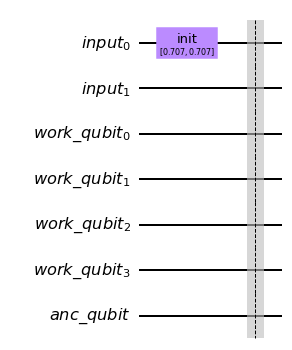

In [32]:
#Create a register for the input qubits
q_input = QuantumRegister(2, name = "input")
#Create a register for the HHL work qubits
q_HHL = QuantumRegister(4, name = "work_qubit")
#Create a register for the ancilla qubit
q_anc = QuantumRegister(1, name = "anc_qubit")
#Create a quantum circuit
qc = QuantumCircuit(q_input,q_HHL,q_anc)
#Initialize the first qubit
qc.append(init_gate,q_input[:1])
qc.barrier()
qc.draw()

After initializing the input qubit, we specify the matrix $A$

In [25]:
dt = 0.1 # time step, unit is in months
T = 6 # period of rotation in months
a = (2*np.pi/T)*dt # the component for our matrix
matrix = np.array([[0,0,1,a],[0,0,-a,1],[1,-a,0,0],[a,1,0,0]]) # our matrix

Then, the HHL circuit can be formed

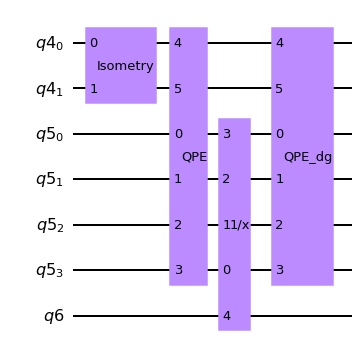

In [26]:
vector = np.array([1,0,0,0]) # The HHL().solve() function requires a matrix and vector
# We give the function |00> so that it doesn't add anything to the input qubits

HHL_circuit = HHL().solve(matrix,vector).state #This is the circuit

HHL_circuit.draw()

We can then pair both circuit

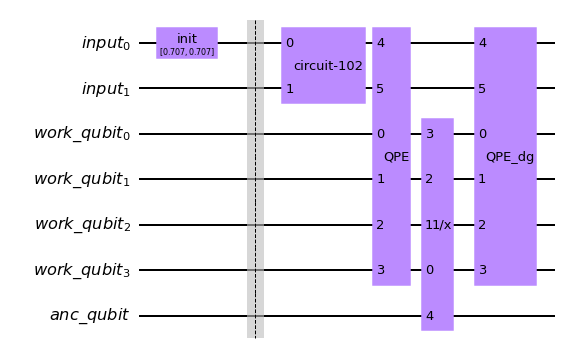

In [35]:
new_qc = qc.compose(HHL_circuit) # Merge both circuits
new_qc.draw()

We then simulate the circuit

In [69]:
backend = Aer.get_backend('statevector_simulator') # use the statevector_simulator as our backend
job_result = execute(new_qc, backend = backend, shots = 1, memory= True).result() # execute the circuit
dirty_state = job_result.get_statevector(new_qc).data # this is the "dirty_state", because we haven't extracted our solutions
print(dirty_state)

[ 5.99782342e-17-1.74651200e-18j -1.52124157e-17+2.70172327e-17j
  1.29921012e-16-1.99070463e-17j  4.01006392e-17+1.32476302e-17j
 -2.12602082e-16+2.12324399e-16j  3.82911950e-18+3.52171829e-16j
  3.74660564e-17-1.83223611e-16j -6.42615828e-17-1.98127968e-16j
 -6.36486644e-17+2.75699097e-16j  5.46867898e-17+3.65557457e-16j
  3.05382270e-16-2.13213044e-16j -2.22212501e-16-1.93603189e-16j
  2.48746631e-16+1.39371829e-16j  1.91520008e-16-3.43940709e-16j
 -2.64046984e-16-1.61938079e-16j -3.38380854e-16-2.48941812e-17j
 -1.28957591e-16+1.27666596e-15j  3.72611642e-16+1.10082230e-15j
  7.49972889e-16-5.48899954e-16j -5.80570806e-16-7.38987925e-16j
 -8.95750709e-17-5.08823395e-17j -4.87848774e-17+7.42122102e-17j
  2.60619682e-17+2.59295604e-17j -6.08145576e-17-6.53376142e-17j
 -7.84374457e-18+3.93052817e-18j -4.61998796e-17-2.02856769e-18j
 -5.00523819e-17-3.87429609e-17j  6.14086765e-17-1.21735193e-17j
 -9.55040812e-17-1.21748888e-17j  4.76697158e-17+4.58694502e-17j
 -5.44496795e-17-1.314305

If we look at the dirty_state variable, most of them are zero, except for the amplitudes that we care about. That is because by the end of the HHL algorithm, the ancilla qubit will be in state $\ket{1}$, and the four work qubits will be in $\ket{0000}$ and our solution will be contained in the input qubits, which means we should look at the amplitudes of the following states
$$
\ket{1}_{\text{anc}}\otimes\ket{0000}_{\text{work}}\otimes\ket{00}_{\text{input}} = \ket{1000000}\\
\ket{1}_{\text{anc}}\otimes\ket{0000}_{\text{work}}\otimes\ket{01}_{\text{input}} = \ket{1000001}\\
\ket{1}_{\text{anc}}\otimes\ket{0000}_{\text{work}}\otimes\ket{10}_{\text{input}} = \ket{1000010}\\
\ket{1}_{\text{anc}}\otimes\ket{0000}_{\text{work}}\otimes\ket{11}_{\text{input}} = \ket{1000011}\\
$$
Each of those binary numbers will correspond to the indices 64, 65, 66, 67 in the dirty_state variable. We will extract them

In [44]:
solution_one = np.real(dirty_state[64:68]) # Extract the real part of the amplitudes, because we are only working with real amplitudes
print(solution_one)

[-3.37389060e-15  4.66250906e-15  6.29615890e-01  7.76906578e-01]


As we can see, we got the solution in the form of
$$
\begin{pmatrix}
0\\ 0\\ x(t + \Delta t)\\ y(t + \Delta t)
\end{pmatrix}
$$

### Running the HHL multiple times

In [83]:
#To run the HHL multiple times, we will define a function to do that for us
def solve_HHL(qc, hhl_circ, num_of_iter, print_circ = False):
    '''
    Explanation for the arguments
    qc: The quantum circuit that initializes our x and y
    hhl_circ: Our HHL circuit
    num_of_iter: Number of iterations, each iteration will add an HHL circuit
    print_circ: If true, it will print the circuit
    '''
    solutions = [] #This variable will contain our solutions
    for i in range(num_of_iter):
        backend = Aer.get_backend('statevector_simulator') # choose the backend
        job_result = execute(qc,backend = backend, shots = 1, memory = False).result()
        solution = job_result.get_statevector(qc).data # Get the statevector

        # We only deal with the real value of the amplitudes
        if i == 0:
            solutions.append(np.real(solution[:4])) #We've only initialized the state, so we're concerned with |00000>|input>
        elif i>0:
            solutions.append(np.real([solution[66],solution[67],solution[64],solution[65]])) # We append (x,y,0,0)
        
        if print_circ:
            print(qc)

        qc.barrier() # Draw a barrier
        if i>0:
            qc.x(1) # We apply x gate to flip our state before feeding it to the next HHL gates
            qc.x(6) # We also return the ancilla qubit to zero
        qc = qc.compose(hhl_circ)
        
    return solutions

### Getting the solutions

In [80]:
solutions = solve_HHL(qc, HHL_circuit, 15) # We will run this 15 times

### Plot the solutions

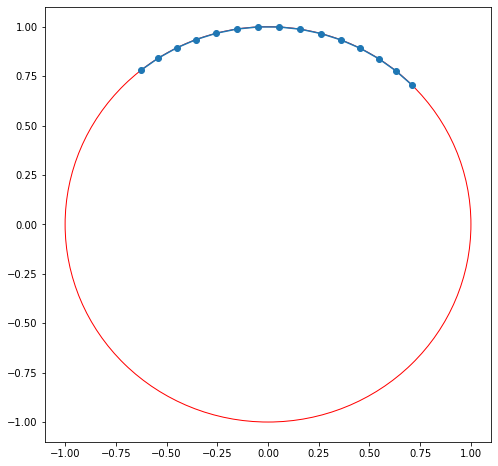

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

In [84]:
x = [] # store the x values
y = [] # store the y values
for s in solutions: # iterate for each solutions
    x.append(s[0]) # each solution vector has the form (x,y,0,0)
    y.append(s[1]) # we are taking the first two elements
    
    
fig, ax= plt.subplots(figsize=(8,8))

plt.plot(x,y,'-o') # plot the result

circle = plt.Circle((0,0), 1,color = 'r', fill = False) #plot a circle as a comparison
ax.add_patch(circle)
plt.ylim([-1.1,1.1])
plt.xlim([-1.1,1.1])
plt.show()
plt.plot

Our initial condition is $[\sqrt{1/2},\sqrt{1/2}]$ and as we can see, we did a quarter of a rotation, because $\Delta t = 0.1$ and we did it for 15 iteration. As we can see, the algorithm is successful.